In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # blacklist tf warning and info

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import h5py

/Users/songzitao/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/songzitao/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/songzitao/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/songzitao/anaconda3/envs/py36/lib

In [3]:
from matplotlib import pyplot as plt
from matplotlib import animation
%matplotlib notebook

In [4]:
from environment.portfolio import PortfolioEnv

In [5]:

eps=1e-8

In [6]:
abbreviations = ['AAPL.O',
                 'ADBE.O',
                 'AMZN.O',
                 'DIS.N',
                 'GOOGL.O',
                 'JNJ.N',
                 'JPM.N',
                 'MSFT.O',
                 'NFLX.O',
                 'PG.N']

In [7]:
import json
with open('configs/{}_default_highassets.json'.format('sac')) as f:
    config = json.load(f)

In [8]:
feature_number = config['input']['feature_number']
window_size = config['input']['window_size']
asset_number = config['input']['asset_number']

actor_learning_rate = config['training']['actor_learning_rate']
critic_learning_rate = config['training']['critic_learning_rate']
batch_size = config['training']['batch_size']
tau = config['training']['tau']        # frequency to update target net parameter
episodes = config['training']['episode']
num_mixture = config['training'].get('num_mixture',None)
num_quart = config['training'].get('num_quart',None)
policy_delay = 2
device = 'cpu'
actor_layers = config['actor_layers']
critic_layers = config['critic_layers']

In [9]:
with h5py.File('./Data/history_stock_price_us_22.h5','r') as f:
    history_stock_price = f['stock_price'][...]
    timestamp = [s.decode('utf-8') for s in f['timestamp']]
    abbreviations = [s.decode('utf-8') for s in f['abbreviations']]
    features = [s.decode('utf-8') for s in f['features']]

In [10]:
train_step = timestamp.index('2017-06-29')
valid_step = timestamp.index('2019-07-01')

In [11]:
train_step

3144

In [12]:
len(timestamp) - valid_step

365

In [13]:
history_stock_price_training = history_stock_price[:,:train_step,:]
history_stock_price_validating = history_stock_price[:,train_step:valid_step,:]
history_stock_price_testing = history_stock_price[:,valid_step:,:]
timestamp_training = timestamp[:train_step]
timestamp_validating = timestamp[train_step:valid_step]
timestamp_testing = timestamp[valid_step:]

In [14]:
env_training = PortfolioEnv(history=history_stock_price_training,
                                abbreviation=abbreviations,
                                timestamp=timestamp_training,
                                steps=3000)

# DDPG

In [15]:
models = []
model_names = []
num_mixture = None
this_models = ['ddp']
episodes_list = [10]
window_length_lst = [20]
use_batch_norm = False
use_obs_normalizer_list = [True]
dtype = tf.float32

In [38]:
model_a = {'name':'qrsac','window_size':12,'batch_norm':False,'obs_norm':True,
           'mixture':3,'epi':100,'best':True}

model_b = {'name':'qrsac','window_size':12,'batch_norm':False,'obs_norm':True,
           'mixture':1,'epi':10,'best':False}

model_c = {'name':'qrsac','window_size':12,'batch_norm':False,'obs_norm':True,
           'mixture':2,'epi':10,'best':False}

model_d = {'name':'qrsac','window_size':12,'batch_norm':False,'obs_norm':True,
           'mixture':4,'epi':10,'best':False}

model_configs = [model_a,model_b,model_c,model_d]

In [39]:
from model.ddpg.stockactor import DDPGActor
from model.ddpg.stockcritic import DDPGCritic
from model.qrsac.stockcritic import QRCritic
from model.ddpg.ddpg import DDPG
from model.sac.stockactor import SACActor
from model.td3.td3 import TD3
from model.sac.sac import SAC
from model.qrsac.qrsac import QRSAC
from model.core.ornstein_uhlenbeck import OrnsteinUhlenbeckActionNoise

In [40]:
from train import get_path, get_variable_scope, test_model, test_model_multiple, \
               obs_normalizer, normalize_obs_logdiff, normalize_obs_diff_2

# Load pretrained weights

In [41]:
models = []
model_names = []
for model_config in model_configs:
    window_size = model_config['window_size']
    use_obs_normalizer = model_config['obs_norm']
    num_mixture = model_config['mixture']
    this_model = model_config['name']
    with open('configs/{}_default_highassets_2.json'.format(this_model)) as f:
        config = json.load(f)
        
    actor_layers = config['actor_layers']
    critic_layers = config['critic_layers']
    
    num_quart = config['training'].get('num_quart',None)
    name = '%s_WIN%d_EPS%d_NOR%s_MIX%s'%(model_config['name'],
                                        model_config['window_size'],
                                         model_config['epi'],
                                         str(model_config['obs_norm']),
                                         str(model_config['mixture']))
    model_names.append(name)
    model_save_path = get_path('weights',model = model_config['name'],
                                         episode=model_config['epi'],
                                         window_size=model_config['window_size'],
                                         use_batch_norm=model_config['batch_norm'], 
                                         use_obs_normalizer=model_config['obs_norm'],
                                         best=model_config['best'],
                                          num_mixture=model_config['mixture'])

    print(model_save_path)
    #model_save_path = './weights/best_sac/sac.ckpt'

    variable_scope = get_variable_scope(window_size=model_config['window_size'],
                                        use_batch_norm=model_config['batch_norm'],
                                        use_obs_normalizer=model_config['obs_norm'])

    actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(asset_number+1))

    tf.reset_default_graph()
    if use_obs_normalizer:
        obs_normalizer = normalize_obs_diff_2
        window_size_ = window_size
#         obs_normalizer = normalize_obs_logdiff
#         window_size_ = window_size - 1
    else:
        window_size_ = window_size
    with tf.variable_scope(variable_scope):
        sess = tf.Session()
        with tf.variable_scope('actor'):
            if this_model[-3:] =='sac':
                dtype = tf.float64
                tf.keras.backend.set_floatx('float64')
                stockactor = SACActor(sess, feature_number = feature_number,
                                              config = config,
                                              action_dim = asset_number + 1,
                                              window_size = window_size_,
                                              num_mixture = num_mixture,
                                              learning_rate = actor_learning_rate,
                                              action_bound=1,
                                              layers = actor_layers,
                                              tau=tau, batch_size=batch_size,dtype=dtype)
            else:
                dtype = tf.float32
                tf.keras.backend.set_floatx('float32')
                stockactor = DDPGActor(sess, feature_number = feature_number,
                                              config = config,
                                              action_dim = asset_number + 1,
                                              window_size = window_size_,
                                              learning_rate = actor_learning_rate,
                                              action_bound=1,
                                              layers = actor_layers,
                                              tau=tau, batch_size=batch_size)
        with tf.variable_scope('critic'):
            if this_model[:2] =='qr':

                stockcritic = QRCritic(sess,    feature_number = feature_number,
                                    config = config,
                                    action_dim = asset_number+1,
                                    window_size = window_size_,
                                    num_quart = num_quart,
                                    learning_rate = critic_learning_rate,
                                    num_actor_vars = stockactor.get_num_trainable_vars(),
                                    layers = critic_layers,
                                    tau=tau, batch_size=batch_size,dtype=dtype)
            else:
                stockcritic = DDPGCritic(sess, feature_number = feature_number,
                                                config = config,
                                                action_dim = asset_number+1,
                                                window_size = window_size_,
                                                learning_rate = critic_learning_rate,
                                                num_actor_vars = stockactor.get_num_trainable_vars(),
                                                layers = critic_layers,
                                                tau=tau, batch_size=batch_size,dtype=dtype)


        if this_model == 'ddpg':
            print('loading ddpg')
            model = DDPG(None,None,sess, actor = stockactor,
                                             critic = stockcritic,
                                             obs_normalizer = obs_normalizer,
                                             actor_noise = actor_noise,
                                             model_save_path = model_save_path,
                                             config = config)

        elif this_model == 'td3' or this_model == 'sac':
            with tf.variable_scope('critic'):
                stockcritic2 = DDPGCritic(sess, feature_number = feature_number,
                                                 config = config,
                                                 action_dim = asset_number+1,
                                                 window_size = window_size_,
                                                 learning_rate = critic_learning_rate,
                                                 num_actor_vars = stockactor.get_num_trainable_vars() + stockcritic.get_num_trainable_vars(),
                                                 layers = critic_layers,
                                                 tau=tau, batch_size=batch_size,dtype=dtype)
            if this_model == 'td3':
                print('loading td3')
                model = TD3(None,None, sess,  actor = stockactor,
                                                 critic1 = stockcritic,
                                                 critic2 = stockcritic2,
                                                 obs_normalizer = obs_normalizer,
                                                 actor_noise = actor_noise,
                                                 policy_delay = policy_delay,
                                                 model_save_path = model_save_path,

                                                 config = config)
            else:
                print('loading sac')
                model = SAC(None,None,sess,  actor = stockactor,
                                                 critic1 = stockcritic,
                                                 critic2 = stockcritic2,
                                                 obs_normalizer = obs_normalizer,
                                                 actor_noise = actor_noise,
                                                 policy_delay = policy_delay,
                                                 model_save_path = model_save_path,
                                                 config = config)
        elif this_model == 'qrsac':
            print("loading qrsac")
            model = QRSAC(None,None, sess,  actor = stockactor,
                                 critic = stockcritic,
                                 obs_normalizer = obs_normalizer,
                                 actor_noise = actor_noise,
                                 policy_delay = policy_delay,
                                 model_save_path = model_save_path,
                                 config = config)
        else:
            raise("Model not Implemented Error")

        model.initialize(load_weights=True, verbose=False)  # change to True to load weights
        models.append(model)

weights/best_qrsac/window_12_no_batch_norm_normalized_eps_100_mix_3_checkpoint.ckpt
(?, 23)
(?, 23)
(?, 1)
(?, 1)
(?, 1)
(?, 23)
(?, 23)
(?, 1)
(?, 1)
(?, 1)
loading qrsac
INFO:tensorflow:Summary name step target1 loss is illegal; using step_target1_loss instead.
INFO:tensorflow:Summary name step Q max is illegal; using step_Q_max instead.
INFO:tensorflow:Summary name step alpha loss is illegal; using step_alpha_loss instead.
INFO:tensorflow:Summary name step target1 loss is illegal; using step_target1_loss instead.
INFO:tensorflow:Summary name step Q max is illegal; using step_Q_max instead.
INFO:tensorflow:Summary name step alpha loss is illegal; using step_alpha_loss instead.
INFO:tensorflow:Restoring parameters from weights/best_qrsac/window_12_no_batch_norm_normalized_eps_100_mix_3_checkpoint.ckpt
weights/qrsac/window_12_no_batch_norm_normalized_eps_10_mix_1_checkpoint.ckpt
(?, 23)
(?, 23)
(?, 1)
(?, 1)
(?, 1)
(?, 23)
(?, 23)
(?, 1)
(?, 1)
(?, 1)
loading qrsac
INFO:tensorflow:Summ

# Testing DDPG Models on Validation set

In [42]:
validation_start_date = '2017-09-13'
test_start_date = '2019-09-13'
history = history_stock_price_validating
timestamp = timestamp_validating
val_steps = 300
test_steps= 200

In [43]:
len(models)

4

In [44]:
from environment.portfolio import sharpe, max_drawdown, AVOL,DDR,ARR

In [45]:
from environment.portfolio import MultiActionPortfolioEnv

MuliActEnv_validating = MultiActionPortfolioEnv(history=history_stock_price_validating,
                                                abbreviation=abbreviations,
                                                timestamp=timestamp_validating,
                                                model_names=model_names,
                                                window_length=50,
                                                steps=val_steps,
                                                sample_start_date=validation_start_date,
                                                feature_num=feature_number)

MuliActEnv_testing = MultiActionPortfolioEnv(history=history_stock_price_testing,
                                                abbreviation=abbreviations,
                                                timestamp=timestamp_testing,
                                                model_names=model_names,
                                                window_length=50,
                                                steps=test_steps,
                                                sample_start_date=test_start_date,
                                                feature_num=feature_number)

Start date: 2019-09-13, End date: 2020-07-01
reward: -0.0072,turn_over_ratio: 0.9989
reward: -0.0055,turn_over_ratio: 0.8171
reward: 0.0028,turn_over_ratio: 0.9826
reward: -0.0069,turn_over_ratio: 0.9875
reward: 0.0078,turn_over_ratio: 0.0018
reward: 0.0035,turn_over_ratio: 0.0074
reward: -0.0026,turn_over_ratio: 0.0050
reward: 0.0054,turn_over_ratio: 0.1076
reward: 0.0032,turn_over_ratio: 0.0038
reward: 0.0010,turn_over_ratio: 0.0638
reward: 0.0000,turn_over_ratio: 0.0048
reward: 0.0031,turn_over_ratio: 0.0163
reward: 0.0071,turn_over_ratio: 0.0007
reward: 0.0021,turn_over_ratio: 0.0615
reward: 0.0033,turn_over_ratio: 0.0014
reward: 0.0055,turn_over_ratio: 0.0729
reward: -0.0049,turn_over_ratio: 0.0012
reward: -0.0014,turn_over_ratio: 0.1540
reward: -0.0013,turn_over_ratio: 0.0024
reward: -0.0048,turn_over_ratio: 0.0850
reward: -0.0149,turn_over_ratio: 0.0010
reward: -0.0009,turn_over_ratio: 0.1416
reward: -0.0070,turn_over_ratio: 0.0046
reward: -0.0146,turn_over_ratio: 0.1768
reward:

reward: -0.0083,turn_over_ratio: 0.0034
reward: 0.0036,turn_over_ratio: 0.0969
reward: 0.0012,turn_over_ratio: 0.0052
reward: -0.0058,turn_over_ratio: 0.0163
reward: 0.0076,turn_over_ratio: 0.0029
reward: -0.0002,turn_over_ratio: 0.0144
reward: 0.0021,turn_over_ratio: 0.0084
reward: 0.0063,turn_over_ratio: 0.1618
reward: 0.0018,turn_over_ratio: 0.0015
reward: 0.0030,turn_over_ratio: 0.0768
reward: -0.0018,turn_over_ratio: 0.0037
reward: 0.0013,turn_over_ratio: 0.1041
reward: -0.0109,turn_over_ratio: 0.0012
reward: -0.0096,turn_over_ratio: 0.1108
reward: -0.0070,turn_over_ratio: 0.0080
reward: -0.0113,turn_over_ratio: 0.0011
reward: 0.0042,turn_over_ratio: 0.0018
reward: 0.0154,turn_over_ratio: 0.0827
reward: 0.0052,turn_over_ratio: 0.0080
reward: 0.0036,turn_over_ratio: 0.2911
reward: 0.0026,turn_over_ratio: 0.0010
reward: -0.0119,turn_over_ratio: 0.0299
reward: 0.0046,turn_over_ratio: 0.0099
reward: 0.0015,turn_over_ratio: 0.1290
reward: 0.0058,turn_over_ratio: 0.0009
reward: 0.0072,t

reward: -0.0066,turn_over_ratio: 0.0017
reward: -0.0024,turn_over_ratio: 0.0358
reward: -0.0037,turn_over_ratio: 0.0089
reward: -0.0055,turn_over_ratio: 0.1018
reward: -0.0152,turn_over_ratio: 0.0013
reward: -0.0059,turn_over_ratio: 0.0600
reward: -0.0038,turn_over_ratio: 0.0053
reward: -0.0141,turn_over_ratio: 0.0793
reward: 0.0025,turn_over_ratio: 0.0044
reward: 0.0189,turn_over_ratio: 0.0187
reward: -0.0005,turn_over_ratio: 0.0093
reward: 0.0013,turn_over_ratio: 0.1536
reward: -0.0413,turn_over_ratio: 0.0013
reward: -0.0249,turn_over_ratio: 0.1130
reward: -0.0261,turn_over_ratio: 0.0092
reward: -0.0405,turn_over_ratio: 0.0236
reward: 0.0168,turn_over_ratio: 0.0044
reward: 0.0058,turn_over_ratio: 0.0646
reward: -0.0099,turn_over_ratio: 0.0090
reward: 0.0122,turn_over_ratio: 0.1723
reward: -0.0269,turn_over_ratio: 0.0075
reward: -0.0071,turn_over_ratio: 0.0142
reward: -0.0271,turn_over_ratio: 0.0120
reward: -0.0262,turn_over_ratio: 0.1500
reward: 0.0556,turn_over_ratio: 0.0013
reward:

reward: 0.0062,turn_over_ratio: 0.0039
reward: 0.0023,turn_over_ratio: 0.0803
reward: -0.0057,turn_over_ratio: 0.0093
reward: 0.0061,turn_over_ratio: 0.0532
reward: -0.0021,turn_over_ratio: 0.0041
reward: -0.0048,turn_over_ratio: 0.1178
reward: -0.0162,turn_over_ratio: 0.0240
reward: -0.0025,turn_over_ratio: 0.9867
reward: 0.0017,turn_over_ratio: 0.0047
reward: 0.0082,turn_over_ratio: 0.1083
reward: 0.0027,turn_over_ratio: 0.0139
reward: -0.0008,turn_over_ratio: 0.9932
reward: 0.0134,turn_over_ratio: 0.0014
reward: 0.0083,turn_over_ratio: 0.1043
reward: 0.0018,turn_over_ratio: 0.0136
reward: 0.0122,turn_over_ratio: 0.0595
reward: 0.0191,turn_over_ratio: 0.0024
reward: 0.0207,turn_over_ratio: 0.0685
reward: 0.0078,turn_over_ratio: 0.0022
reward: 0.0191,turn_over_ratio: 0.0529
reward: -0.0205,turn_over_ratio: 0.0055
reward: -0.0222,turn_over_ratio: 0.0610
reward: -0.0191,turn_over_ratio: 0.0088
reward: -0.0210,turn_over_ratio: 0.0697
reward: -0.0144,turn_over_ratio: 0.0011
reward: -0.014

<IPython.core.display.Javascript object>


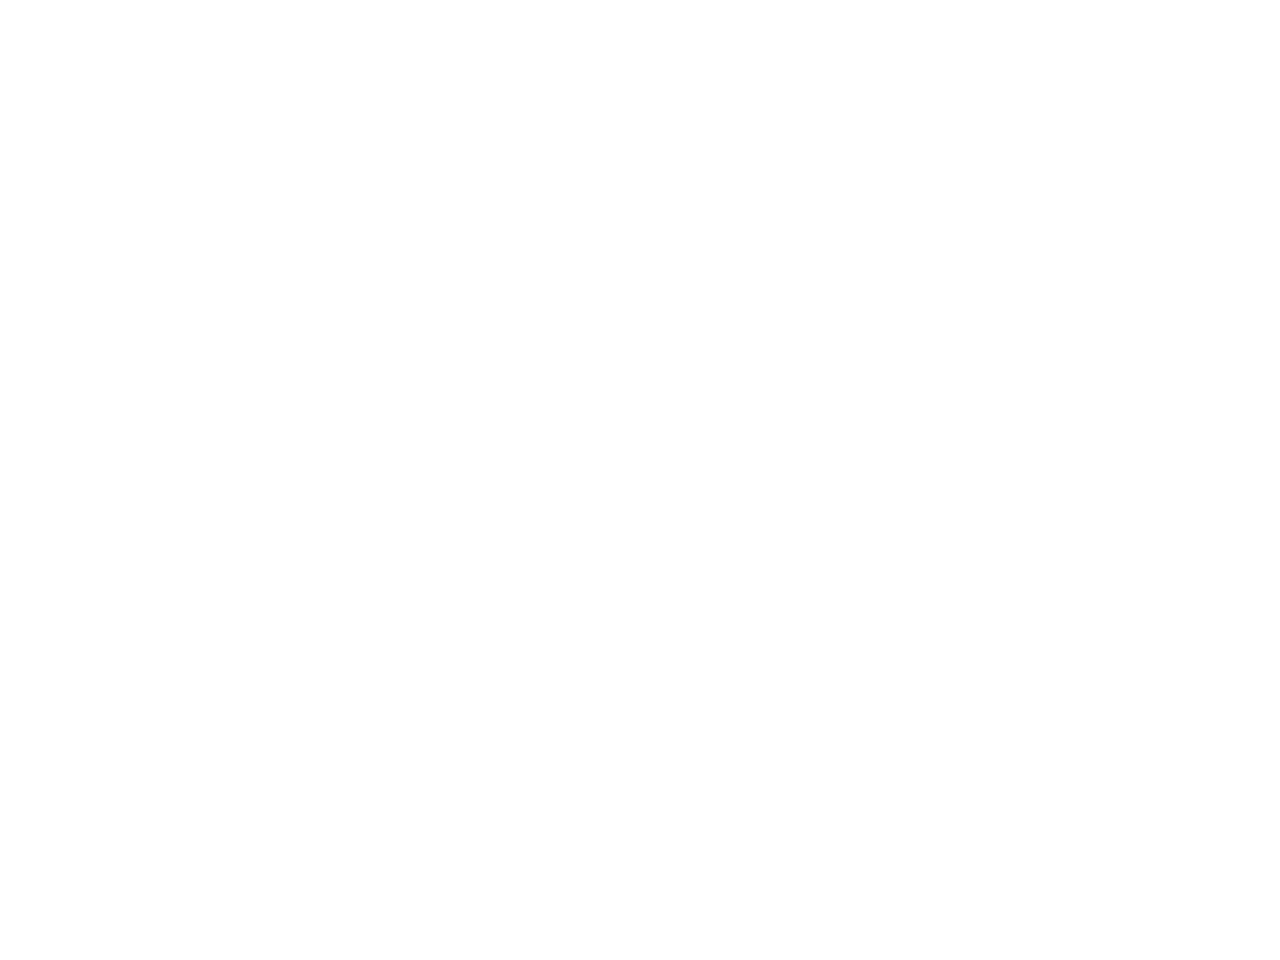

<IPython.core.display.Javascript object>


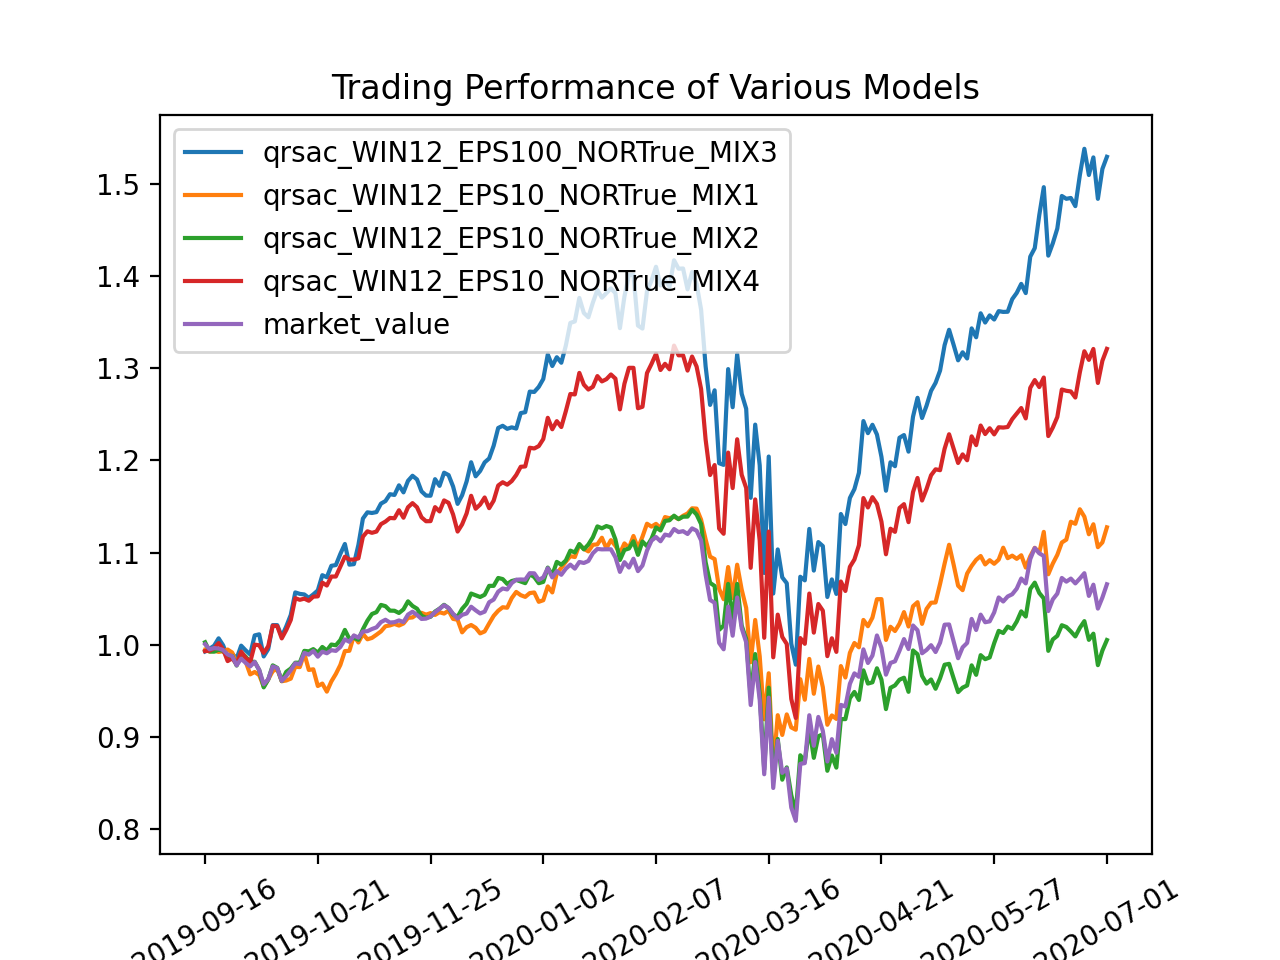

In [46]:
envs_test = test_model_multiple(env=MuliActEnv_testing,models=models, policy_delay=1)
envs_test.render()

In [ ]:
envs = test_model_multiple(env=MuliActEnv_validating,models=models, policy_delay=1)
envs_df = pd.DataFrame(envs.infos)

In [ ]:
model_names

In [47]:
steps = test_steps
sharpes_dict = {model_name: [] for model_name in model_names}
sharpes_dict['market_value'] = []
mdd_dict = {model_name: [] for model_name in model_names}
mdd_dict['market_value'] = []

arr_dict = {model_name: [] for model_name in model_names}
arr_dict['market_value'] = []
avol_dict = {model_name: [] for model_name in model_names}
avol_dict['market_value'] = []

ddr_dict = {model_name: [] for model_name in model_names}
ddr_dict['market_value'] = []

asr_dict = {model_name: [] for model_name in model_names}
asr_dict['market_value'] = []
for i in range(10):
    envs = test_model_multiple(env=MuliActEnv_testing,models=models, policy_delay=1)
    envs_df = pd.DataFrame(envs.infos)
    for model_name in model_names:
        sharpes_dict[model_name].append(sharpe((envs_df[model_name]/ envs_df[model_name].shift()) -1,freq=steps))
        mdd_dict[model_name].append(max_drawdown(envs_df[model_name]))
        arr = ARR(envs_df[model_name],freq=steps)
        avol = AVOL((envs_df[model_name]- 1),freq=steps)
        arr_dict[model_name].append(arr)
        avol_dict[model_name].append(avol)
        ddr_dict[model_name].append(DDR(envs_df['%s_rate_of_return'%(model_name)],arr))
        asr_dict[model_name].append(arr/avol)
    sharpes_dict['market_value'].append(sharpe((envs_df['market_value']- envs_df['market_value'].shift()), freq=steps))
    mdd_dict['market_value'].append(max_drawdown(envs_df['market_value']))
    avol_market = AVOL((envs_df['market_value'] -1),freq=steps)
    avol_dict['market_value'].append(avol)
    arr_market = ARR(envs_df["market_value"],freq=steps)
    arr_dict['market_value'].append(arr_market)
    ddr_dict['market_value'].append(DDR(envs_df['return'],arr_market))
    asr_dict['market_value'].append(arr_market/avol_market)

Start date: 2019-09-13, End date: 2020-07-01
reward: -0.0072,turn_over_ratio: 0.9989
reward: -0.0051,turn_over_ratio: 0.7948
reward: 0.0028,turn_over_ratio: 0.9826
reward: -0.0075,turn_over_ratio: 0.9935
reward: 0.0078,turn_over_ratio: 0.0019
reward: 0.0036,turn_over_ratio: 0.1201
reward: -0.0026,turn_over_ratio: 0.0051
reward: 0.0066,turn_over_ratio: 0.1111
reward: 0.0032,turn_over_ratio: 0.0038
reward: 0.0011,turn_over_ratio: 0.0192
reward: 0.0000,turn_over_ratio: 0.0067
reward: 0.0029,turn_over_ratio: 0.0809
reward: 0.0071,turn_over_ratio: 0.0007
reward: 0.0022,turn_over_ratio: 0.0046
reward: 0.0033,turn_over_ratio: 0.0042
reward: 0.0059,turn_over_ratio: 0.0717
reward: -0.0049,turn_over_ratio: 0.0011
reward: -0.0013,turn_over_ratio: 0.1218
reward: -0.0013,turn_over_ratio: 0.0018
reward: -0.0047,turn_over_ratio: 0.0478
reward: -0.0149,turn_over_ratio: 0.0010
reward: -0.0012,turn_over_ratio: 0.0741
reward: -0.0069,turn_over_ratio: 0.0122
reward: -0.0025,turn_over_ratio: 0.9889
reward:

reward: 0.0076,turn_over_ratio: 0.0029
reward: -0.0003,turn_over_ratio: 0.0156
reward: 0.0021,turn_over_ratio: 0.0075
reward: 0.0067,turn_over_ratio: 0.0057
reward: 0.0018,turn_over_ratio: 0.0015
reward: 0.0029,turn_over_ratio: 0.1007
reward: -0.0018,turn_over_ratio: 0.0033
reward: 0.0011,turn_over_ratio: 0.0598
reward: -0.0109,turn_over_ratio: 0.0011
reward: -0.0095,turn_over_ratio: 0.1001
reward: -0.0070,turn_over_ratio: 0.0034
reward: -0.0113,turn_over_ratio: 0.1102
reward: 0.0042,turn_over_ratio: 0.0017
reward: 0.0148,turn_over_ratio: 0.1009
reward: 0.0052,turn_over_ratio: 0.0048
reward: 0.0042,turn_over_ratio: 0.0287
reward: 0.0026,turn_over_ratio: 0.0009
reward: -0.0110,turn_over_ratio: 0.0134
reward: 0.0045,turn_over_ratio: 0.0070
reward: 0.0013,turn_over_ratio: 0.3753
reward: 0.0058,turn_over_ratio: 0.0009
reward: 0.0074,turn_over_ratio: 0.0588
reward: 0.0015,turn_over_ratio: 0.0021
reward: 0.0034,turn_over_ratio: 0.3133
reward: 0.0105,turn_over_ratio: 0.0017
reward: 0.0013,tur

reward: 0.0004,turn_over_ratio: 0.0005
reward: 0.0008,turn_over_ratio: 0.0334
reward: 0.0017,turn_over_ratio: 0.0104
reward: -0.0002,turn_over_ratio: 0.2029
reward: 0.0098,turn_over_ratio: 0.0007
reward: -0.0005,turn_over_ratio: 0.0579
reward: 0.0022,turn_over_ratio: 0.0034
reward: 0.0079,turn_over_ratio: 0.1135
reward: 0.0103,turn_over_ratio: 0.0030
reward: 0.0016,turn_over_ratio: 0.1016
reward: 0.0021,turn_over_ratio: 0.0028
reward: 0.0084,turn_over_ratio: 0.0387
reward: -0.0066,turn_over_ratio: 0.0016
reward: -0.0023,turn_over_ratio: 0.0096
reward: -0.0037,turn_over_ratio: 0.0066
reward: -0.0052,turn_over_ratio: 0.0808
reward: -0.0152,turn_over_ratio: 0.0014
reward: -0.0055,turn_over_ratio: 0.0371
reward: -0.0038,turn_over_ratio: 0.0038
reward: -0.0151,turn_over_ratio: 0.1185
reward: 0.0025,turn_over_ratio: 0.0042
reward: 0.0191,turn_over_ratio: 0.0378
reward: -0.0005,turn_over_ratio: 0.0132
reward: 0.0013,turn_over_ratio: 0.0552
reward: -0.0413,turn_over_ratio: 0.0012
reward: -0.02

reward: 0.0017,turn_over_ratio: 0.0047
reward: 0.0076,turn_over_ratio: 0.0736
reward: 0.0026,turn_over_ratio: 0.0135
reward: 0.0015,turn_over_ratio: 0.0823
reward: 0.0134,turn_over_ratio: 0.0015
reward: 0.0089,turn_over_ratio: 0.0242
reward: 0.0019,turn_over_ratio: 0.0020
reward: 0.0125,turn_over_ratio: 0.0048
reward: 0.0191,turn_over_ratio: 0.0024
reward: 0.0210,turn_over_ratio: 0.0402
reward: 0.0079,turn_over_ratio: 0.0048
reward: -0.0025,turn_over_ratio: 0.9924
reward: -0.0205,turn_over_ratio: 0.0055
reward: -0.0228,turn_over_ratio: 0.0163
reward: -0.0191,turn_over_ratio: 0.0121
reward: -0.0234,turn_over_ratio: 0.9906
reward: -0.0144,turn_over_ratio: 0.0010
reward: -0.0166,turn_over_ratio: 0.0068
reward: -0.0138,turn_over_ratio: 0.0045
reward: -0.0142,turn_over_ratio: 0.0979
reward: 0.0166,turn_over_ratio: 0.0013
reward: 0.0005,turn_over_ratio: 0.0144
reward: 0.0151,turn_over_ratio: 0.0061
reward: 0.0164,turn_over_ratio: 0.0879
reward: 0.0218,turn_over_ratio: 0.0016
reward: 0.0173,t

reward: -0.0067,turn_over_ratio: 0.0008
reward: -0.0082,turn_over_ratio: 0.0202
reward: -0.0077,turn_over_ratio: 0.0012
reward: -0.0078,turn_over_ratio: 0.1518
reward: 0.0003,turn_over_ratio: 0.0008
reward: -0.0033,turn_over_ratio: 0.0591
reward: 0.0037,turn_over_ratio: 0.0022
reward: -0.0009,turn_over_ratio: 0.1234
reward: 0.0090,turn_over_ratio: 0.0009
reward: 0.0037,turn_over_ratio: 0.0232
reward: 0.0056,turn_over_ratio: 0.0095
reward: 0.0092,turn_over_ratio: 0.0190
reward: 0.0116,turn_over_ratio: 0.0012
reward: 0.0034,turn_over_ratio: 0.0385
reward: -0.0042,turn_over_ratio: 0.0085
reward: 0.0075,turn_over_ratio: 0.1946
reward: 0.0033,turn_over_ratio: 0.0041
reward: -0.0009,turn_over_ratio: 0.0695
reward: 0.0011,turn_over_ratio: 0.0014
reward: -0.0025,turn_over_ratio: 0.9833
reward: -0.0028,turn_over_ratio: 0.0014
reward: 0.0107,turn_over_ratio: 0.0468
reward: 0.0117,turn_over_ratio: 0.0040
reward: -0.0043,turn_over_ratio: 0.9900
reward: 0.0041,turn_over_ratio: 0.0030
reward: 0.0007

reward: 0.0158,turn_over_ratio: 0.0005
reward: 0.0031,turn_over_ratio: 0.0691
reward: 0.0072,turn_over_ratio: 0.0081
reward: 0.0149,turn_over_ratio: 0.1480
reward: -0.0042,turn_over_ratio: 0.0036
reward: -0.0011,turn_over_ratio: 0.0518
reward: -0.0047,turn_over_ratio: 0.0081
reward: -0.0025,turn_over_ratio: 0.9935
reward: 0.0052,turn_over_ratio: 0.0008
reward: -0.0101,turn_over_ratio: 0.0162
reward: -0.0070,turn_over_ratio: 0.0025
reward: 0.0015,turn_over_ratio: 0.9913
reward: 0.0115,turn_over_ratio: 0.0032
reward: 0.0036,turn_over_ratio: 0.0388
reward: 0.0022,turn_over_ratio: 0.0121
reward: -0.0025,turn_over_ratio: 0.9921
reward: 0.0125,turn_over_ratio: 0.0022
reward: 0.0091,turn_over_ratio: 0.0857
reward: 0.0089,turn_over_ratio: 0.0011
reward: 0.0090,turn_over_ratio: 0.9864
reward: 0.0012,turn_over_ratio: 0.0025
reward: 0.0039,turn_over_ratio: 0.1254
reward: 0.0057,turn_over_ratio: 0.0135
reward: 0.0005,turn_over_ratio: 0.2550
reward: 0.0187,turn_over_ratio: 0.0007
reward: 0.0278,tur

reward: 0.0034,turn_over_ratio: 0.0034
reward: -0.0318,turn_over_ratio: 0.0094
reward: 0.0040,turn_over_ratio: 0.0113
reward: 0.0030,turn_over_ratio: 0.0769
reward: 0.0230,turn_over_ratio: 0.0055
reward: 0.0482,turn_over_ratio: 0.0295
reward: 0.0295,turn_over_ratio: 0.0187
reward: 0.0245,turn_over_ratio: 0.0925
reward: 0.0251,turn_over_ratio: 0.0042
reward: 0.0342,turn_over_ratio: 0.0645
reward: 0.0033,turn_over_ratio: 0.0136
reward: 0.0297,turn_over_ratio: 0.0441
reward: -0.0070,turn_over_ratio: 0.0071
reward: 0.0237,turn_over_ratio: 0.1210
reward: 0.0221,turn_over_ratio: 0.0321
reward: -0.0089,turn_over_ratio: 0.1341
reward: -0.0724,turn_over_ratio: 0.0079
reward: -0.0205,turn_over_ratio: 0.0472
reward: -0.0478,turn_over_ratio: 0.0107
reward: -0.0717,turn_over_ratio: 0.0880
reward: -0.0158,turn_over_ratio: 0.0065
reward: 0.0011,turn_over_ratio: 0.0948
reward: -0.0062,turn_over_ratio: 0.0160
reward: -0.0168,turn_over_ratio: 0.1898
reward: 0.0412,turn_over_ratio: 0.0031
reward: 0.0281,

reward: 0.0076,turn_over_ratio: 0.0033
reward: 0.0003,turn_over_ratio: 0.0380
reward: 0.0074,turn_over_ratio: 0.0091
reward: 0.0072,turn_over_ratio: 0.0212
reward: 0.0023,turn_over_ratio: 0.0011
reward: 0.0007,turn_over_ratio: 0.0870
reward: 0.0038,turn_over_ratio: 0.0039
reward: 0.0008,turn_over_ratio: 0.1476
reward: -0.0049,turn_over_ratio: 0.0018
reward: -0.0109,turn_over_ratio: 0.0089
reward: -0.0032,turn_over_ratio: 0.0067
reward: -0.0060,turn_over_ratio: 0.0408
reward: 0.0226,turn_over_ratio: 0.0033
reward: 0.0122,turn_over_ratio: 0.0671
reward: 0.0142,turn_over_ratio: 0.0157
reward: 0.0215,turn_over_ratio: 0.1203
reward: 0.0093,turn_over_ratio: 0.0040
reward: 0.0110,turn_over_ratio: 0.0480
reward: 0.0074,turn_over_ratio: 0.0048
reward: -0.0025,turn_over_ratio: 0.9934
reward: 0.0298,turn_over_ratio: 0.0016
reward: -0.0038,turn_over_ratio: 0.0579
reward: -0.0000,turn_over_ratio: 0.0092
reward: 0.0242,turn_over_ratio: 0.9912
reward: 0.0105,turn_over_ratio: 0.0089
reward: 0.0164,tur

reward: -0.0050,turn_over_ratio: 0.0053
reward: 0.0098,turn_over_ratio: 0.0182
reward: 0.0027,turn_over_ratio: 0.0061
reward: -0.0033,turn_over_ratio: 0.1273
reward: 0.0052,turn_over_ratio: 0.0021
reward: -0.0020,turn_over_ratio: 0.0639
reward: -0.0014,turn_over_ratio: 0.0062
reward: 0.0039,turn_over_ratio: 0.0504
reward: 0.0218,turn_over_ratio: 0.0017
reward: 0.0036,turn_over_ratio: 0.0796
reward: 0.0060,turn_over_ratio: 0.0069
reward: 0.0197,turn_over_ratio: 0.1353
reward: 0.0001,turn_over_ratio: 0.0052
reward: -0.0123,turn_over_ratio: 0.0738
reward: 0.0034,turn_over_ratio: 0.0044
reward: -0.0025,turn_over_ratio: 0.9940
reward: 0.0006,turn_over_ratio: 0.0013
reward: 0.0005,turn_over_ratio: 0.0415
reward: 0.0040,turn_over_ratio: 0.0151
reward: -0.0027,turn_over_ratio: 0.9915
reward: 0.0019,turn_over_ratio: 0.0013
reward: 0.0009,turn_over_ratio: 0.0026
reward: 0.0019,turn_over_ratio: 0.0132
reward: 0.0021,turn_over_ratio: 0.0469
reward: 0.0025,turn_over_ratio: 0.0007
reward: 0.0017,tur

reward: 0.0048,turn_over_ratio: 0.0013
reward: 0.0012,turn_over_ratio: 0.0160
reward: 0.0025,turn_over_ratio: 0.0023
reward: 0.0023,turn_over_ratio: 0.9874
reward: 0.0068,turn_over_ratio: 0.0010
reward: -0.0022,turn_over_ratio: 0.1090
reward: 0.0049,turn_over_ratio: 0.0089
reward: 0.0057,turn_over_ratio: 0.0146
reward: -0.0017,turn_over_ratio: 0.0017
reward: 0.0091,turn_over_ratio: 0.1215
reward: -0.0007,turn_over_ratio: 0.0046
reward: -0.0008,turn_over_ratio: 0.0694
reward: -0.0023,turn_over_ratio: 0.0009
reward: -0.0070,turn_over_ratio: 0.0432
reward: -0.0011,turn_over_ratio: 0.0036
reward: -0.0026,turn_over_ratio: 0.1918
reward: 0.0034,turn_over_ratio: 0.0012
reward: 0.0072,turn_over_ratio: 0.0391
reward: -0.0013,turn_over_ratio: 0.0045
reward: 0.0037,turn_over_ratio: 0.1151
reward: -0.0064,turn_over_ratio: 0.0016
reward: -0.0084,turn_over_ratio: 0.0080
reward: -0.0135,turn_over_ratio: 0.0034
reward: -0.0066,turn_over_ratio: 0.1719
reward: -0.0031,turn_over_ratio: 0.0009
reward: 0.0

reward: -0.0407,turn_over_ratio: 0.0064
reward: -0.0259,turn_over_ratio: 0.0680
reward: -0.0299,turn_over_ratio: 0.0168
reward: -0.0390,turn_over_ratio: 0.0317
reward: 0.0129,turn_over_ratio: 0.0039
reward: 0.0204,turn_over_ratio: 0.1196
reward: 0.0108,turn_over_ratio: 0.0070
reward: 0.0134,turn_over_ratio: 0.0521
reward: -0.0022,turn_over_ratio: 0.0016
reward: 0.0050,turn_over_ratio: 0.0794
reward: -0.0035,turn_over_ratio: 0.0063
reward: -0.0024,turn_over_ratio: 0.0528
reward: 0.0142,turn_over_ratio: 0.0023
reward: -0.0024,turn_over_ratio: 0.0195
reward: -0.0065,turn_over_ratio: 0.0151
reward: 0.0151,turn_over_ratio: 0.0454
reward: 0.0225,turn_over_ratio: 0.0077
reward: 0.0114,turn_over_ratio: 0.0392
reward: 0.0113,turn_over_ratio: 0.0178
reward: -0.0025,turn_over_ratio: 0.9907
reward: 0.0058,turn_over_ratio: 0.0042
reward: 0.0046,turn_over_ratio: 0.0431
reward: 0.0033,turn_over_ratio: 0.0138
reward: 0.0039,turn_over_ratio: 0.9921
reward: -0.0022,turn_over_ratio: 0.0029
reward: 0.0015

reward: -0.0142,turn_over_ratio: 0.0027
reward: -0.0112,turn_over_ratio: 0.0909
reward: -0.0167,turn_over_ratio: 0.0081
reward: -0.0154,turn_over_ratio: 0.2885
reward: 0.0117,turn_over_ratio: 0.0014
reward: 0.0080,turn_over_ratio: 0.0451
reward: 0.0097,turn_over_ratio: 0.0063
reward: 0.0111,turn_over_ratio: 0.1175
reward: -0.0279,turn_over_ratio: 0.0010
reward: -0.0201,turn_over_ratio: 0.0525
reward: -0.0266,turn_over_ratio: 0.0045
reward: -0.0252,turn_over_ratio: 0.0754
reward: 0.0220,turn_over_ratio: 0.0039
reward: 0.0026,turn_over_ratio: 0.0470
reward: 0.0152,turn_over_ratio: 0.0237
reward: 0.0188,turn_over_ratio: 0.1305
reward: 0.0128,turn_over_ratio: 0.0032
reward: 0.0138,turn_over_ratio: 0.0313
reward: 0.0127,turn_over_ratio: 0.0135
reward: 0.0134,turn_over_ratio: 0.0161
Start date: 2019-09-13, End date: 2020-07-01
reward: -0.0072,turn_over_ratio: 0.9989
reward: -0.0059,turn_over_ratio: 0.8401
reward: 0.0028,turn_over_ratio: 0.9831
reward: -0.0071,turn_over_ratio: 0.9891
reward: 

reward: -0.0083,turn_over_ratio: 0.0034
reward: 0.0036,turn_over_ratio: 0.0246
reward: 0.0012,turn_over_ratio: 0.0065
reward: -0.0073,turn_over_ratio: 0.0600
reward: 0.0076,turn_over_ratio: 0.0029
reward: -0.0000,turn_over_ratio: 0.0264
reward: 0.0021,turn_over_ratio: 0.0074
reward: 0.0049,turn_over_ratio: 0.2818
reward: 0.0018,turn_over_ratio: 0.0015
reward: 0.0032,turn_over_ratio: 0.0276
reward: -0.0018,turn_over_ratio: 0.0060
reward: 0.0007,turn_over_ratio: 0.2634
reward: -0.0109,turn_over_ratio: 0.0012
reward: -0.0090,turn_over_ratio: 0.0308
reward: -0.0070,turn_over_ratio: 0.0030
reward: -0.0119,turn_over_ratio: 0.1845
reward: 0.0042,turn_over_ratio: 0.0017
reward: 0.0154,turn_over_ratio: 0.0301
reward: 0.0052,turn_over_ratio: 0.0065
reward: 0.0041,turn_over_ratio: 0.0998
reward: 0.0026,turn_over_ratio: 0.0009
reward: -0.0106,turn_over_ratio: 0.0368
reward: 0.0045,turn_over_ratio: 0.0166
reward: 0.0020,turn_over_ratio: 0.0270
reward: 0.0058,turn_over_ratio: 0.0009
reward: 0.0077,t

reward: 0.0152,turn_over_ratio: 0.0017
reward: -0.0008,turn_over_ratio: 0.0862
reward: 0.0017,turn_over_ratio: 0.0018
reward: 0.0132,turn_over_ratio: 0.0194
reward: 0.0022,turn_over_ratio: 0.0043
reward: 0.0014,turn_over_ratio: 0.1135
reward: 0.0014,turn_over_ratio: 0.0041
reward: 0.0023,turn_over_ratio: 0.0722
reward: 0.0004,turn_over_ratio: 0.0005
reward: 0.0009,turn_over_ratio: 0.0095
reward: 0.0017,turn_over_ratio: 0.0036
reward: 0.0000,turn_over_ratio: 0.1147
reward: 0.0098,turn_over_ratio: 0.0007
reward: -0.0005,turn_over_ratio: 0.0656
reward: 0.0022,turn_over_ratio: 0.0068
reward: 0.0085,turn_over_ratio: 0.3460
reward: 0.0103,turn_over_ratio: 0.0030
reward: 0.0019,turn_over_ratio: 0.0102
reward: 0.0020,turn_over_ratio: 0.0036
reward: 0.0087,turn_over_ratio: 0.0871
reward: -0.0066,turn_over_ratio: 0.0017
reward: -0.0025,turn_over_ratio: 0.0466
reward: -0.0037,turn_over_ratio: 0.0038
reward: -0.0052,turn_over_ratio: 0.2371
reward: -0.0152,turn_over_ratio: 0.0013
reward: -0.0055,tu

reward: 0.0108,turn_over_ratio: 0.0025
reward: 0.0037,turn_over_ratio: 0.0421
reward: 0.0050,turn_over_ratio: 0.0120
reward: 0.0099,turn_over_ratio: 0.0768
reward: 0.0065,turn_over_ratio: 0.0044
reward: -0.0095,turn_over_ratio: 0.0063
reward: -0.0092,turn_over_ratio: 0.0098
reward: 0.0032,turn_over_ratio: 0.0615
reward: 0.0119,turn_over_ratio: 0.0058
reward: 0.0201,turn_over_ratio: 0.0050
reward: 0.0012,turn_over_ratio: 0.0047
reward: 0.0120,turn_over_ratio: 0.1499
reward: 0.0062,turn_over_ratio: 0.0038
reward: 0.0024,turn_over_ratio: 0.0150
reward: -0.0058,turn_over_ratio: 0.0105
reward: 0.0066,turn_over_ratio: 0.0303
reward: -0.0021,turn_over_ratio: 0.0041
reward: -0.0047,turn_over_ratio: 0.0258
reward: -0.0161,turn_over_ratio: 0.0137
reward: -0.0030,turn_over_ratio: 0.0748
reward: 0.0017,turn_over_ratio: 0.0047
reward: 0.0079,turn_over_ratio: 0.0136
reward: 0.0027,turn_over_ratio: 0.0089
reward: 0.0014,turn_over_ratio: 0.0906
reward: 0.0134,turn_over_ratio: 0.0014
reward: 0.0089,tur

reward: -0.0029,turn_over_ratio: 0.0391
reward: -0.0032,turn_over_ratio: 0.0128
reward: -0.0025,turn_over_ratio: 0.0713
reward: -0.0074,turn_over_ratio: 0.0015
reward: -0.0173,turn_over_ratio: 0.0751
reward: -0.0081,turn_over_ratio: 0.0037
reward: -0.0077,turn_over_ratio: 0.0042
reward: 0.0122,turn_over_ratio: 0.0012
reward: 0.0026,turn_over_ratio: 0.0503
reward: 0.0010,turn_over_ratio: 0.0068
reward: 0.0116,turn_over_ratio: 0.0720
reward: -0.0036,turn_over_ratio: 0.0028
reward: -0.0073,turn_over_ratio: 0.0817
reward: -0.0121,turn_over_ratio: 0.0050
reward: -0.0058,turn_over_ratio: 0.0291
reward: -0.0175,turn_over_ratio: 0.0026
reward: -0.0076,turn_over_ratio: 0.0344
reward: -0.0142,turn_over_ratio: 0.0071
reward: -0.0170,turn_over_ratio: 0.1084
reward: 0.0104,turn_over_ratio: 0.0019
reward: 0.0096,turn_over_ratio: 0.0297
reward: 0.0078,turn_over_ratio: 0.0040
reward: 0.0100,turn_over_ratio: 0.0448
reward: 0.0069,turn_over_ratio: 0.0012
reward: 0.0050,turn_over_ratio: 0.0213
reward: 0.

reward: 0.0092,turn_over_ratio: 0.0035
reward: 0.0052,turn_over_ratio: 0.1049
reward: 0.0022,turn_over_ratio: 0.0032
reward: 0.0079,turn_over_ratio: 0.0997
reward: 0.0026,turn_over_ratio: 0.0019
reward: 0.0007,turn_over_ratio: 0.1309
reward: -0.0031,turn_over_ratio: 0.0051
reward: 0.0033,turn_over_ratio: 0.0169
reward: -0.0009,turn_over_ratio: 0.0009
reward: -0.0012,turn_over_ratio: 0.0765
reward: -0.0057,turn_over_ratio: 0.0046
reward: -0.0005,turn_over_ratio: 0.0942
reward: 0.0020,turn_over_ratio: 0.0015
reward: 0.0081,turn_over_ratio: 0.0786
reward: 0.0034,turn_over_ratio: 0.0101
reward: 0.0033,turn_over_ratio: 0.1264
reward: -0.0088,turn_over_ratio: 0.0006
reward: -0.0008,turn_over_ratio: 0.0375
reward: -0.0036,turn_over_ratio: 0.0072
reward: -0.0097,turn_over_ratio: 0.0923
reward: 0.0101,turn_over_ratio: 0.0022
reward: -0.0020,turn_over_ratio: 0.0305
reward: -0.0047,turn_over_ratio: 0.0045
reward: 0.0083,turn_over_ratio: 0.1831
reward: -0.0013,turn_over_ratio: 0.0037
reward: -0.00

reward: 0.0268,turn_over_ratio: 0.0041
reward: 0.0174,turn_over_ratio: 0.0877
reward: 0.0126,turn_over_ratio: 0.0101
reward: 0.0266,turn_over_ratio: 0.1943
reward: -0.0084,turn_over_ratio: 0.0043
reward: -0.0198,turn_over_ratio: 0.0220
reward: -0.0205,turn_over_ratio: 0.0066
reward: -0.0103,turn_over_ratio: 0.0167
reward: -0.0306,turn_over_ratio: 0.0024
reward: -0.0201,turn_over_ratio: 0.0374
reward: -0.0246,turn_over_ratio: 0.0076
reward: -0.0282,turn_over_ratio: 0.1828
reward: 0.0468,turn_over_ratio: 0.0023
reward: 0.0086,turn_over_ratio: 0.0056
reward: 0.0404,turn_over_ratio: 0.0146
reward: 0.0454,turn_over_ratio: 0.0916
reward: 0.0034,turn_over_ratio: 0.0034
reward: -0.0314,turn_over_ratio: 0.0730
reward: 0.0040,turn_over_ratio: 0.0132
reward: -0.0025,turn_over_ratio: 0.9868
reward: 0.0230,turn_over_ratio: 0.0054
reward: 0.0469,turn_over_ratio: 0.0189
reward: 0.0295,turn_over_ratio: 0.0198
reward: 0.0228,turn_over_ratio: 0.9908
reward: 0.0251,turn_over_ratio: 0.0042
reward: 0.0303,

reward: 0.0023,turn_over_ratio: 0.0011
reward: 0.0022,turn_over_ratio: 0.0633
reward: 0.0005,turn_over_ratio: 0.0044
reward: -0.0025,turn_over_ratio: 0.9939
reward: -0.0017,turn_over_ratio: 0.0043
reward: 0.0050,turn_over_ratio: 0.0448
reward: 0.0106,turn_over_ratio: 0.0120
reward: -0.0040,turn_over_ratio: 0.9961
reward: 0.0110,turn_over_ratio: 0.0042
reward: 0.0090,turn_over_ratio: 0.0772
reward: 0.0003,turn_over_ratio: 0.0038
reward: 0.0090,turn_over_ratio: 0.2521
reward: 0.0076,turn_over_ratio: 0.0033
reward: 0.0003,turn_over_ratio: 0.0277
reward: 0.0074,turn_over_ratio: 0.0161
reward: 0.0070,turn_over_ratio: 0.0128
reward: 0.0023,turn_over_ratio: 0.0012
reward: 0.0008,turn_over_ratio: 0.0200
reward: 0.0038,turn_over_ratio: 0.0087
reward: 0.0010,turn_over_ratio: 0.0445
reward: -0.0049,turn_over_ratio: 0.0019
reward: -0.0104,turn_over_ratio: 0.0068
reward: -0.0033,turn_over_ratio: 0.0103
reward: -0.0058,turn_over_ratio: 0.1337
reward: 0.0226,turn_over_ratio: 0.0033
reward: 0.0124,tur

reward: 0.0059,turn_over_ratio: 0.0022
reward: 0.0127,turn_over_ratio: 0.0174
reward: 0.0063,turn_over_ratio: 0.0026
reward: 0.0061,turn_over_ratio: 0.0678
reward: -0.0200,turn_over_ratio: 0.0014
reward: 0.0000,turn_over_ratio: 0.0287
reward: -0.0042,turn_over_ratio: 0.0061
reward: -0.0175,turn_over_ratio: 0.1121
reward: -0.0050,turn_over_ratio: 0.0054
reward: 0.0089,turn_over_ratio: 0.0906
reward: 0.0027,turn_over_ratio: 0.0053
reward: -0.0038,turn_over_ratio: 0.0785
reward: 0.0052,turn_over_ratio: 0.0021
reward: -0.0020,turn_over_ratio: 0.1356
reward: -0.0014,turn_over_ratio: 0.0069
reward: 0.0042,turn_over_ratio: 0.0085
reward: 0.0218,turn_over_ratio: 0.0017
reward: 0.0038,turn_over_ratio: 0.0329
reward: 0.0060,turn_over_ratio: 0.0057
reward: 0.0184,turn_over_ratio: 0.0364
reward: 0.0001,turn_over_ratio: 0.0051
reward: -0.0114,turn_over_ratio: 0.0048
reward: 0.0033,turn_over_ratio: 0.0046
reward: -0.0016,turn_over_ratio: 0.1848
reward: 0.0006,turn_over_ratio: 0.0014
reward: 0.0001,t

reward: 0.0068,turn_over_ratio: 0.0009
reward: -0.0018,turn_over_ratio: 0.0084
reward: 0.0049,turn_over_ratio: 0.0040
reward: 0.0054,turn_over_ratio: 0.0216
reward: -0.0017,turn_over_ratio: 0.0018
reward: 0.0113,turn_over_ratio: 0.0553
reward: -0.0007,turn_over_ratio: 0.0083
reward: -0.0012,turn_over_ratio: 0.1973
reward: -0.0023,turn_over_ratio: 0.0009
reward: -0.0075,turn_over_ratio: 0.0500
reward: -0.0011,turn_over_ratio: 0.0069
reward: -0.0022,turn_over_ratio: 0.0417
reward: 0.0034,turn_over_ratio: 0.0011
reward: 0.0073,turn_over_ratio: 0.0851
reward: -0.0013,turn_over_ratio: 0.0078
reward: 0.0034,turn_over_ratio: 0.2486
reward: -0.0064,turn_over_ratio: 0.0015
reward: -0.0093,turn_over_ratio: 0.1381
reward: -0.0135,turn_over_ratio: 0.0040
reward: -0.0066,turn_over_ratio: 0.2160
reward: -0.0031,turn_over_ratio: 0.0010
reward: 0.0058,turn_over_ratio: 0.1258
reward: -0.0015,turn_over_ratio: 0.0044
reward: -0.0020,turn_over_ratio: 0.0422
reward: 0.0147,turn_over_ratio: 0.0014
reward: 0

reward: 0.0204,turn_over_ratio: 0.0052
reward: 0.0116,turn_over_ratio: 0.1118
reward: 0.0228,turn_over_ratio: 0.0097
reward: 0.0212,turn_over_ratio: 0.1921
reward: -0.0065,turn_over_ratio: 0.0029
reward: -0.0023,turn_over_ratio: 0.0737
reward: -0.0106,turn_over_ratio: 0.0092
reward: -0.0060,turn_over_ratio: 0.0418
reward: 0.0414,turn_over_ratio: 0.0024
reward: 0.0346,turn_over_ratio: 0.0733
reward: 0.0245,turn_over_ratio: 0.0078
reward: 0.0410,turn_over_ratio: 0.0285
reward: -0.0407,turn_over_ratio: 0.0064
reward: -0.0254,turn_over_ratio: 0.0788
reward: -0.0299,turn_over_ratio: 0.0243
reward: -0.0386,turn_over_ratio: 0.2143
reward: 0.0129,turn_over_ratio: 0.0040
reward: 0.0207,turn_over_ratio: 0.0717
reward: 0.0108,turn_over_ratio: 0.0088
reward: 0.0132,turn_over_ratio: 0.1209
reward: -0.0022,turn_over_ratio: 0.0016
reward: 0.0049,turn_over_ratio: 0.0495
reward: -0.0036,turn_over_ratio: 0.0095
reward: -0.0023,turn_over_ratio: 0.0517
reward: 0.0142,turn_over_ratio: 0.0022
reward: -0.002

reward: 0.0017,turn_over_ratio: 0.0008
reward: 0.0166,turn_over_ratio: 0.0289
reward: -0.0015,turn_over_ratio: 0.0091
reward: 0.0013,turn_over_ratio: 0.0036
reward: -0.0148,turn_over_ratio: 0.0015
reward: -0.0101,turn_over_ratio: 0.0411
reward: -0.0148,turn_over_ratio: 0.0048
reward: -0.0142,turn_over_ratio: 0.0810
reward: 0.0189,turn_over_ratio: 0.0021
reward: 0.0140,turn_over_ratio: 0.0459
reward: 0.0098,turn_over_ratio: 0.0073
reward: 0.0171,turn_over_ratio: 0.0944
reward: 0.0054,turn_over_ratio: 0.0041
reward: -0.0095,turn_over_ratio: 0.0290
reward: 0.0018,turn_over_ratio: 0.0065
reward: 0.0042,turn_over_ratio: 0.0318
reward: -0.0142,turn_over_ratio: 0.0027
reward: -0.0109,turn_over_ratio: 0.0296
reward: -0.0166,turn_over_ratio: 0.0086
reward: -0.0154,turn_over_ratio: 0.0914
reward: 0.0117,turn_over_ratio: 0.0013
reward: 0.0078,turn_over_ratio: 0.0418
reward: 0.0097,turn_over_ratio: 0.0041
reward: 0.0114,turn_over_ratio: 0.0144
reward: -0.0279,turn_over_ratio: 0.0010
reward: -0.020

reward: -0.0036,turn_over_ratio: 0.0027
reward: 0.0020,turn_over_ratio: 0.0115
reward: 0.0045,turn_over_ratio: 0.0083
reward: -0.0026,turn_over_ratio: 0.0184
reward: 0.0068,turn_over_ratio: 0.0011
reward: 0.0033,turn_over_ratio: 0.0692
reward: 0.0043,turn_over_ratio: 0.0068
reward: 0.0074,turn_over_ratio: 0.0130
reward: 0.0046,turn_over_ratio: 0.0023
reward: -0.0003,turn_over_ratio: 0.0468
reward: -0.0046,turn_over_ratio: 0.0099
reward: 0.0037,turn_over_ratio: 0.2735
reward: -0.0059,turn_over_ratio: 0.0013
reward: 0.0001,turn_over_ratio: 0.0033
reward: -0.0064,turn_over_ratio: 0.0017
reward: -0.0058,turn_over_ratio: 0.0216
reward: -0.0079,turn_over_ratio: 0.0009
reward: 0.0034,turn_over_ratio: 0.1583
reward: -0.0044,turn_over_ratio: 0.0061
reward: -0.0025,turn_over_ratio: 0.9933
reward: -0.0055,turn_over_ratio: 0.0018
reward: -0.0059,turn_over_ratio: 0.0168
reward: -0.0011,turn_over_ratio: 0.0021
reward: -0.0072,turn_over_ratio: 0.9896
reward: -0.0023,turn_over_ratio: 0.0017
reward: 0.

reward: 0.0098,turn_over_ratio: 0.0051
reward: 0.0029,turn_over_ratio: 0.0307
reward: -0.0032,turn_over_ratio: 0.0132
reward: -0.0025,turn_over_ratio: 0.9880
reward: -0.0054,turn_over_ratio: 0.0026
reward: -0.0112,turn_over_ratio: 0.0361
reward: -0.0030,turn_over_ratio: 0.0098
reward: -0.0076,turn_over_ratio: 0.9933
reward: 0.0073,turn_over_ratio: 0.0028
reward: -0.0011,turn_over_ratio: 0.1225
reward: 0.0073,turn_over_ratio: 0.0086
reward: 0.0054,turn_over_ratio: 0.2088
reward: -0.0065,turn_over_ratio: 0.0016
reward: -0.0037,turn_over_ratio: 0.1044
reward: 0.0027,turn_over_ratio: 0.0051
reward: -0.0068,turn_over_ratio: 0.0772
reward: 0.0207,turn_over_ratio: 0.0016
reward: 0.0103,turn_over_ratio: 0.0865
reward: 0.0103,turn_over_ratio: 0.0153
reward: 0.0210,turn_over_ratio: 0.1628
reward: -0.0117,turn_over_ratio: 0.0043
reward: -0.0082,turn_over_ratio: 0.1160
reward: -0.0040,turn_over_ratio: 0.0086
reward: -0.0104,turn_over_ratio: 0.2778
reward: 0.0152,turn_over_ratio: 0.0016
reward: -0.

reward: -0.0265,turn_over_ratio: 0.0015
reward: -0.0341,turn_over_ratio: 0.0332
reward: -0.0160,turn_over_ratio: 0.0067
reward: -0.0258,turn_over_ratio: 0.0201
reward: 0.0071,turn_over_ratio: 0.0048
reward: -0.0010,turn_over_ratio: 0.0835
reward: 0.0054,turn_over_ratio: 0.0099
reward: 0.0067,turn_over_ratio: 0.0766
reward: -0.0031,turn_over_ratio: 0.0036
reward: -0.0040,turn_over_ratio: 0.0324
reward: -0.0013,turn_over_ratio: 0.0045
reward: -0.0033,turn_over_ratio: 0.1162
reward: 0.0179,turn_over_ratio: 0.0009
reward: 0.0016,turn_over_ratio: 0.0690
reward: 0.0080,turn_over_ratio: 0.0112
reward: 0.0161,turn_over_ratio: 0.1829
reward: 0.0050,turn_over_ratio: 0.0047
reward: 0.0062,turn_over_ratio: 0.0385
reward: -0.0071,turn_over_ratio: 0.0094
reward: 0.0041,turn_over_ratio: 0.0815
reward: -0.0224,turn_over_ratio: 0.0019
reward: -0.0205,turn_over_ratio: 0.0396
reward: -0.0283,turn_over_ratio: 0.0127
reward: -0.0230,turn_over_ratio: 0.0873
reward: 0.0094,turn_over_ratio: 0.0018
reward: 0.0

reward: 0.0071,turn_over_ratio: 0.0007
reward: 0.0019,turn_over_ratio: 0.0519
reward: 0.0032,turn_over_ratio: 0.0121
reward: 0.0059,turn_over_ratio: 0.0749
reward: -0.0049,turn_over_ratio: 0.0011
reward: -0.0010,turn_over_ratio: 0.0044
reward: -0.0013,turn_over_ratio: 0.0050
reward: -0.0047,turn_over_ratio: 0.0366
reward: -0.0149,turn_over_ratio: 0.0010
reward: -0.0010,turn_over_ratio: 0.1175
reward: -0.0069,turn_over_ratio: 0.0050
reward: -0.0125,turn_over_ratio: 0.1919
reward: -0.0005,turn_over_ratio: 0.0030
reward: 0.0023,turn_over_ratio: 0.0130
reward: 0.0050,turn_over_ratio: 0.0146
reward: -0.0011,turn_over_ratio: 0.2144
reward: -0.0147,turn_over_ratio: 0.0010
reward: -0.0114,turn_over_ratio: 0.0636
reward: -0.0137,turn_over_ratio: 0.0077
reward: -0.0151,turn_over_ratio: 0.1398
reward: 0.0105,turn_over_ratio: 0.0013
reward: 0.0054,turn_over_ratio: 0.0642
reward: 0.0148,turn_over_ratio: 0.0118
reward: 0.0100,turn_over_ratio: 0.0792
reward: -0.0012,turn_over_ratio: 0.0015
reward: -0

reward: -0.0109,turn_over_ratio: 0.0010
reward: -0.0084,turn_over_ratio: 0.1086
reward: -0.0070,turn_over_ratio: 0.0106
reward: -0.0113,turn_over_ratio: 0.0672
reward: 0.0042,turn_over_ratio: 0.0017
reward: 0.0156,turn_over_ratio: 0.1093
reward: 0.0052,turn_over_ratio: 0.0080
reward: 0.0043,turn_over_ratio: 0.0151
reward: 0.0026,turn_over_ratio: 0.0010
reward: -0.0113,turn_over_ratio: 0.0173
reward: 0.0046,turn_over_ratio: 0.0067
reward: 0.0017,turn_over_ratio: 0.0354
reward: 0.0058,turn_over_ratio: 0.0009
reward: 0.0074,turn_over_ratio: 0.0331
reward: 0.0015,turn_over_ratio: 0.0020
reward: 0.0034,turn_over_ratio: 0.0860
reward: 0.0105,turn_over_ratio: 0.0015
reward: 0.0013,turn_over_ratio: 0.0732
reward: 0.0039,turn_over_ratio: 0.0083
reward: 0.0088,turn_over_ratio: 0.1413
reward: -0.0105,turn_over_ratio: 0.0027
reward: -0.0012,turn_over_ratio: 0.0099
reward: -0.0018,turn_over_ratio: 0.0011
reward: -0.0097,turn_over_ratio: 0.0402
reward: -0.0005,turn_over_ratio: 0.0018
reward: -0.0033

reward: -0.0152,turn_over_ratio: 0.0013
reward: -0.0056,turn_over_ratio: 0.0266
reward: -0.0038,turn_over_ratio: 0.0028
reward: -0.0146,turn_over_ratio: 0.0588
reward: 0.0025,turn_over_ratio: 0.0043
reward: 0.0202,turn_over_ratio: 0.0694
reward: -0.0005,turn_over_ratio: 0.0090
reward: 0.0011,turn_over_ratio: 0.0820
reward: -0.0413,turn_over_ratio: 0.0013
reward: -0.0255,turn_over_ratio: 0.1432
reward: -0.0261,turn_over_ratio: 0.0046
reward: -0.0424,turn_over_ratio: 0.2899
reward: 0.0168,turn_over_ratio: 0.0044
reward: 0.0060,turn_over_ratio: 0.0690
reward: -0.0099,turn_over_ratio: 0.0106
reward: 0.0111,turn_over_ratio: 0.3791
reward: -0.0269,turn_over_ratio: 0.0076
reward: -0.0075,turn_over_ratio: 0.0699
reward: -0.0271,turn_over_ratio: 0.0165
reward: -0.0258,turn_over_ratio: 0.1225
reward: 0.0556,turn_over_ratio: 0.0013
reward: 0.0187,turn_over_ratio: 0.0244
reward: 0.0340,turn_over_ratio: 0.0077
reward: 0.0471,turn_over_ratio: 0.0722
reward: 0.0545,turn_over_ratio: 0.0089
reward: 0.0

reward: 0.0191,turn_over_ratio: 0.0024
reward: 0.0178,turn_over_ratio: 0.0896
reward: 0.0079,turn_over_ratio: 0.0078
reward: 0.0176,turn_over_ratio: 0.2127
reward: -0.0205,turn_over_ratio: 0.0055
reward: -0.0211,turn_over_ratio: 0.0249
reward: -0.0191,turn_over_ratio: 0.0107
reward: -0.0214,turn_over_ratio: 0.2047
reward: -0.0144,turn_over_ratio: 0.0010
reward: -0.0171,turn_over_ratio: 0.1231
reward: -0.0138,turn_over_ratio: 0.0052
reward: -0.0144,turn_over_ratio: 0.2302
reward: 0.0166,turn_over_ratio: 0.0013
reward: 0.0006,turn_over_ratio: 0.0420
reward: 0.0151,turn_over_ratio: 0.0130
reward: 0.0161,turn_over_ratio: 0.1368
reward: 0.0218,turn_over_ratio: 0.0015
reward: 0.0165,turn_over_ratio: 0.0586
reward: 0.0092,turn_over_ratio: 0.0108
reward: -0.0025,turn_over_ratio: 0.9893
reward: 0.0060,turn_over_ratio: 0.0047
reward: -0.0054,turn_over_ratio: 0.1193
reward: 0.0122,turn_over_ratio: 0.0109
reward: 0.0011,turn_over_ratio: 0.9825
reward: -0.0067,turn_over_ratio: 0.0014
reward: 0.0059

reward: -0.0067,turn_over_ratio: 0.0008
reward: -0.0079,turn_over_ratio: 0.0233
reward: -0.0077,turn_over_ratio: 0.0015
reward: -0.0077,turn_over_ratio: 0.1839
reward: 0.0003,turn_over_ratio: 0.0008
reward: -0.0033,turn_over_ratio: 0.0369
reward: 0.0037,turn_over_ratio: 0.0034
reward: -0.0012,turn_over_ratio: 0.2181
reward: 0.0090,turn_over_ratio: 0.0009
reward: 0.0037,turn_over_ratio: 0.0227
reward: 0.0056,turn_over_ratio: 0.0095
reward: 0.0091,turn_over_ratio: 0.0580
reward: 0.0116,turn_over_ratio: 0.0012
reward: 0.0031,turn_over_ratio: 0.0094
reward: -0.0041,turn_over_ratio: 0.0031
reward: 0.0077,turn_over_ratio: 0.1267
reward: 0.0033,turn_over_ratio: 0.0040
reward: -0.0009,turn_over_ratio: 0.0919
reward: 0.0010,turn_over_ratio: 0.0085
reward: 0.0022,turn_over_ratio: 0.2468
reward: -0.0028,turn_over_ratio: 0.0014
reward: 0.0116,turn_over_ratio: 0.0063
reward: 0.0117,turn_over_ratio: 0.0021
reward: -0.0014,turn_over_ratio: 0.2091
reward: 0.0041,turn_over_ratio: 0.0032
reward: 0.0005,

reward: -0.0013,turn_over_ratio: 0.0037
reward: -0.0006,turn_over_ratio: 0.0838
reward: -0.0010,turn_over_ratio: 0.0008
reward: -0.0038,turn_over_ratio: 0.9800
reward: 0.0158,turn_over_ratio: 0.0005
reward: 0.0032,turn_over_ratio: 0.0338
reward: 0.0072,turn_over_ratio: 0.0055
reward: 0.0134,turn_over_ratio: 0.0123
reward: -0.0042,turn_over_ratio: 0.0035
reward: -0.0016,turn_over_ratio: 0.1252
reward: -0.0047,turn_over_ratio: 0.0065
reward: -0.0048,turn_over_ratio: 0.1983
reward: 0.0052,turn_over_ratio: 0.0007
reward: -0.0100,turn_over_ratio: 0.1000
reward: -0.0070,turn_over_ratio: 0.0076
reward: 0.0044,turn_over_ratio: 0.0547
reward: 0.0115,turn_over_ratio: 0.0032
reward: 0.0036,turn_over_ratio: 0.0153
reward: 0.0022,turn_over_ratio: 0.0055
reward: 0.0104,turn_over_ratio: 0.1607
reward: 0.0125,turn_over_ratio: 0.0022
reward: 0.0093,turn_over_ratio: 0.0505
reward: 0.0088,turn_over_ratio: 0.0021
reward: -0.0025,turn_over_ratio: 0.9896
reward: 0.0012,turn_over_ratio: 0.0026
reward: 0.0038

reward: -0.0084,turn_over_ratio: 0.0043
reward: -0.0198,turn_over_ratio: 0.0213
reward: -0.0206,turn_over_ratio: 0.0068
reward: -0.0113,turn_over_ratio: 0.0468
reward: -0.0306,turn_over_ratio: 0.0024
reward: -0.0211,turn_over_ratio: 0.0560
reward: -0.0246,turn_over_ratio: 0.0064
reward: -0.0279,turn_over_ratio: 0.0744
reward: 0.0468,turn_over_ratio: 0.0022
reward: 0.0089,turn_over_ratio: 0.1317
reward: 0.0403,turn_over_ratio: 0.0190
reward: 0.0460,turn_over_ratio: 0.0169
reward: 0.0034,turn_over_ratio: 0.0034
reward: -0.0281,turn_over_ratio: 0.0495
reward: 0.0039,turn_over_ratio: 0.0149
reward: 0.0027,turn_over_ratio: 0.1164
reward: 0.0230,turn_over_ratio: 0.0054
reward: 0.0493,turn_over_ratio: 0.1411
reward: 0.0295,turn_over_ratio: 0.0173
reward: 0.0260,turn_over_ratio: 0.2114
reward: 0.0251,turn_over_ratio: 0.0042
reward: 0.0307,turn_over_ratio: 0.0962
reward: 0.0032,turn_over_ratio: 0.0030
reward: 0.0293,turn_over_ratio: 0.0983
reward: -0.0070,turn_over_ratio: 0.0071
reward: 0.0233,

reward: -0.0189,turn_over_ratio: 0.0020
reward: -0.0192,turn_over_ratio: 0.0082
reward: -0.0072,turn_over_ratio: 0.0043
reward: -0.0208,turn_over_ratio: 0.1267
reward: 0.0059,turn_over_ratio: 0.0044
reward: 0.0036,turn_over_ratio: 0.0137
reward: 0.0033,turn_over_ratio: 0.0120
reward: 0.0067,turn_over_ratio: 0.1294
reward: 0.0023,turn_over_ratio: 0.0011
reward: 0.0021,turn_over_ratio: 0.0192
reward: 0.0005,turn_over_ratio: 0.0049
reward: 0.0016,turn_over_ratio: 0.0566
reward: -0.0017,turn_over_ratio: 0.0044
reward: 0.0048,turn_over_ratio: 0.1166
reward: 0.0106,turn_over_ratio: 0.0122
reward: 0.0012,turn_over_ratio: 0.1213
reward: 0.0110,turn_over_ratio: 0.0043
reward: 0.0090,turn_over_ratio: 0.1028
reward: 0.0003,turn_over_ratio: 0.0032
reward: 0.0091,turn_over_ratio: 0.0612
reward: 0.0076,turn_over_ratio: 0.0034
reward: 0.0004,turn_over_ratio: 0.0071
reward: 0.0074,turn_over_ratio: 0.0077
reward: 0.0068,turn_over_ratio: 0.1273
reward: 0.0023,turn_over_ratio: 0.0011
reward: 0.0009,turn_

reward: 0.0040,turn_over_ratio: 0.0012
reward: 0.0116,turn_over_ratio: 0.0711
reward: 0.0070,turn_over_ratio: 0.0018
reward: 0.0034,turn_over_ratio: 0.0227
reward: -0.0042,turn_over_ratio: 0.0013
reward: 0.0019,turn_over_ratio: 0.0338
reward: -0.0036,turn_over_ratio: 0.0109
reward: -0.0051,turn_over_ratio: 0.0758
reward: 0.0129,turn_over_ratio: 0.0012
reward: 0.0144,turn_over_ratio: 0.0699
reward: 0.0097,turn_over_ratio: 0.0055
reward: 0.0119,turn_over_ratio: 0.1359
reward: 0.0059,turn_over_ratio: 0.0023
reward: 0.0128,turn_over_ratio: 0.0520
reward: 0.0063,turn_over_ratio: 0.0057
reward: 0.0061,turn_over_ratio: 0.0022
reward: -0.0200,turn_over_ratio: 0.0014
reward: -0.0001,turn_over_ratio: 0.0589
reward: -0.0042,turn_over_ratio: 0.0084
reward: -0.0177,turn_over_ratio: 0.0790
reward: -0.0050,turn_over_ratio: 0.0054
reward: 0.0090,turn_over_ratio: 0.0660
reward: 0.0027,turn_over_ratio: 0.0053
reward: -0.0041,turn_over_ratio: 0.0913
reward: 0.0052,turn_over_ratio: 0.0021
reward: -0.0019,

reward: -0.0017,turn_over_ratio: 0.0018
reward: -0.0020,turn_over_ratio: 0.0110
reward: -0.0048,turn_over_ratio: 0.0039
reward: -0.0032,turn_over_ratio: 0.0417
reward: 0.0149,turn_over_ratio: 0.0014
reward: 0.0090,turn_over_ratio: 0.0248
reward: 0.0053,turn_over_ratio: 0.0093
reward: 0.0126,turn_over_ratio: 0.0362
reward: -0.0109,turn_over_ratio: 0.0036
reward: -0.0032,turn_over_ratio: 0.0881
reward: -0.0040,turn_over_ratio: 0.0086
reward: -0.0083,turn_over_ratio: 0.0095
reward: -0.0011,turn_over_ratio: 0.0032
reward: -0.0015,turn_over_ratio: 0.0501
reward: 0.0046,turn_over_ratio: 0.0037
reward: -0.0018,turn_over_ratio: 0.3315
reward: 0.0048,turn_over_ratio: 0.0014
reward: 0.0012,turn_over_ratio: 0.0203
reward: 0.0025,turn_over_ratio: 0.0055
reward: 0.0051,turn_over_ratio: 0.0174
reward: 0.0068,turn_over_ratio: 0.0010
reward: -0.0019,turn_over_ratio: 0.0429
reward: 0.0049,turn_over_ratio: 0.0021
reward: 0.0055,turn_over_ratio: 0.2130
reward: -0.0017,turn_over_ratio: 0.0018
reward: 0.01

reward: 0.0465,turn_over_ratio: 0.0061
reward: 0.0400,turn_over_ratio: 0.0309
reward: 0.0338,turn_over_ratio: 0.0109
reward: 0.0464,turn_over_ratio: 0.9893
reward: -0.0178,turn_over_ratio: 0.0035
reward: -0.0142,turn_over_ratio: 0.0523
reward: -0.0064,turn_over_ratio: 0.0163
reward: -0.0180,turn_over_ratio: 0.0828
reward: 0.0165,turn_over_ratio: 0.0048
reward: 0.0170,turn_over_ratio: 0.0831
reward: 0.0155,turn_over_ratio: 0.0106
reward: 0.0158,turn_over_ratio: 0.0453
reward: -0.0061,turn_over_ratio: 0.0018
reward: -0.0198,turn_over_ratio: 0.0726
reward: 0.0051,turn_over_ratio: 0.0053
reward: -0.0080,turn_over_ratio: 0.1576
reward: -0.0200,turn_over_ratio: 0.0030
reward: -0.0156,turn_over_ratio: 0.0211
reward: -0.0109,turn_over_ratio: 0.0140
reward: -0.0185,turn_over_ratio: 0.1441
reward: 0.0204,turn_over_ratio: 0.0053
reward: 0.0112,turn_over_ratio: 0.0361
reward: 0.0228,turn_over_ratio: 0.0149
reward: 0.0226,turn_over_ratio: 0.1425
reward: -0.0065,turn_over_ratio: 0.0028
reward: -0.00

reward: 0.0105,turn_over_ratio: 0.0091
reward: 0.0155,turn_over_ratio: 0.0350
reward: -0.0086,turn_over_ratio: 0.0141
reward: 0.0111,turn_over_ratio: 0.2054
reward: -0.0387,turn_over_ratio: 0.0062
reward: -0.0241,turn_over_ratio: 0.0611
reward: -0.0323,turn_over_ratio: 0.0178
reward: -0.0400,turn_over_ratio: 0.2049
reward: -0.0164,turn_over_ratio: 0.0015
reward: -0.0055,turn_over_ratio: 0.0150
reward: -0.0114,turn_over_ratio: 0.0108
reward: -0.0154,turn_over_ratio: 0.1269
reward: 0.0282,turn_over_ratio: 0.0018
reward: 0.0210,turn_over_ratio: 0.0050
reward: 0.0225,turn_over_ratio: 0.0053
reward: 0.0265,turn_over_ratio: 0.0477
reward: -0.0005,turn_over_ratio: 0.0018
reward: 0.0021,turn_over_ratio: 0.1093
reward: -0.0110,turn_over_ratio: 0.0040
reward: -0.0011,turn_over_ratio: 0.1356
reward: -0.0101,turn_over_ratio: 0.0042
reward: -0.0006,turn_over_ratio: 0.0900
reward: -0.0061,turn_over_ratio: 0.0115
reward: -0.0094,turn_over_ratio: 0.1402
reward: 0.0017,turn_over_ratio: 0.0007
reward: 0

In [48]:
sharpe_dict_avg = {model_name : np.mean(sharpes_dict[model_name]) for model_name in model_names}
sharpe_dict_avg['market_value'] = np.mean(sharpes_dict['market_value'])
sharpe_dict_avg

{'qrsac_WIN12_EPS100_NORTrue_MIX3': 1.361469743798572,
 'qrsac_WIN12_EPS10_NORTrue_MIX1': 0.6270545208670448,
 'qrsac_WIN12_EPS10_NORTrue_MIX2': 0.16261506504167675,
 'qrsac_WIN12_EPS10_NORTrue_MIX4': 1.0132875835443318,
 'market_value': 0.22867629692844016}

In [49]:
df = pd.DataFrame()

In [50]:
mdd_dict_avg = {model_name : np.mean(mdd_dict[model_name]) for model_name in model_names}
mdd_dict_avg['market_value'] = np.mean(mdd_dict['market_value'])
df['mdd'] = pd.Series(mdd_dict_avg)

In [51]:
arr_dict_avg = {model_name : np.mean(arr_dict[model_name]) for model_name in model_names}
arr_dict_avg['market_value'] = np.mean(arr_dict['market_value'])
df['arr'] = pd.Series(arr_dict_avg)

In [52]:
avol_dict_avg = {model_name : np.mean(avol_dict[model_name]) for model_name in model_names}
avol_dict_avg['market_value'] = np.mean(avol_dict['market_value'])
df['avol'] = pd.Series(avol_dict_avg)

In [53]:
asr_dict_avg = {model_name : np.mean(asr_dict[model_name]) for model_name in model_names}
asr_dict_avg['market_value'] = np.mean(asr_dict['market_value'])
df['asr'] = pd.Series(asr_dict_avg)

In [54]:
ddr_dict_avg = {model_name : np.mean(ddr_dict[model_name]) for model_name in model_names}
ddr_dict_avg['market_value'] = np.mean(ddr_dict['market_value'])
df['ddr'] = pd.Series(ddr_dict_avg)

In [55]:
df

,mdd,arr,avol,asr,ddr
qrsac_WIN12_EPS100_NORTrue_MIX3,-0.035288,0.691876,0.163886,4.221683,5.603915
qrsac_WIN12_EPS10_NORTrue_MIX1,-0.119327,0.180539,0.071235,2.529996,1.735432
qrsac_WIN12_EPS10_NORTrue_MIX2,-0.286880,0.003782,0.077325,0.048906,0.036590
qrsac_WIN12_EPS10_NORTrue_MIX4,-0.122835,0.421975,0.120850,3.482823,3.715301
market_value,-0.281698,0.083116,0.120850,1.169899,0.092762


In [56]:
df.to_csv('metrics_ablationstudy.csv')

In [ ]:
model_names

In [ ]:
envs = test_model_multiple(env=MuliActEnv_validating,models=models, policy_delay=1)
envs.render()

In [ ]:
models[0].predict_single(np.random.rand(11,20,4))

In [ ]:
weights = []
for i in range(val_steps+1):
    weights.append(envs.sim[0].infos[i]['weights'])
weights_matrix = np.concatenate([weights],axis=1)

In [ ]:
def barlist(i):
    return envs.sim[0].infos[i]['weights']

In [ ]:
from matplotlib import pyplot as plt
from matplotlib import animation
%matplotlib inline

In [ ]:
new_abbreviations = ['Cash'] + abbreviations

In [ ]:
def plot_ith_asset(ax,i,steps):
    start_date_index = timestamp.index(validation_start_date)
    timestamp_plot = timestamp[start_date_index:start_date_index+steps]
    ax.set_title('%s'%(new_abbreviations[i]))
    color = "tab:red"
    ax.plot(np.arange(0,steps),weights_matrix[1:,i],color=color)
    ax.set_ylabel('Porfolio weights',color=color)
    ax.tick_params(axis='y',labelcolor=color)
    
    if i != 0:
        close_price = history[i-1,...][start_date_index:start_date_index+steps,3]
        ax2 = ax.twinx()
        color = "tab:blue"
        ax2.set_ylabel('%s Close Price' %(new_abbreviations[i]),color=color)
        ax2.plot(np.arange(0,steps),close_price,color=color)
        ax2.tick_params(axis='y',labelcolor=color)

    ax.set_xticks(np.arange(0,steps)[::15])
    ax.set_xticklabels(timestamp_plot[::15], rotation='45')
    
    return ax

In [ ]:
fig, axes = plt.subplots(nrows=6,ncols=4,sharex=True,sharey=True,figsize=(15,12))
for i in range(0,asset_number+1):
    row = i // 4
    col = i % 4
    ax = plot_ith_asset(axes[row,col],i,val_steps)
    plt.tight_layout()
fig.delaxes(axes[5,3])
#fig.savefig('./figs/ddpg.pdf')

# Interactive display

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
n = 100 # frame numbers
x = ['Cash'] + abbreviations
barcollection = ax.bar(x, barlist(1))


def animate(i):
    y = barlist(i+1)
    for i, b in enumerate(barcollection):
        
        b.set_height(y[i])
        
anim=animation.FuncAnimation(fig,animate,repeat=False,blit=False,frames=n,
                             interval=100)
#anim.save('mymovie.mp4',writer=animation.FFMpegWriter(fps=5))
plt.show()

In [ ]:
start_date = envs.src.start_date
start_date

# Random Stratety on Validation set

In [ ]:
env_validating = PortfolioEnv(history=history,
                                abbreviation=abbreviations,
                                timestamp=timestamp,
                                window_length=max(window_length_lst),
                                steps=steps,
                                sample_start_date=validation_start_date)

In [ ]:
pre_obs, ground_truth_obs = env_validating.reset()
done = False
while not done:
    action = np.random.rand(11)
    observation, onestep_r, done, info = env_validating.step(action)

In [ ]:
env_validating.render()

# Visualize results

In [ ]:
from environment.portfolio import sharpe, max_drawdown

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
%matplotlib inline

In [ ]:
envs_df = pd.DataFrame(envs.infos)
#envs_df['date'] =  pd.to_datetime(envs_df['date'], format='%Y-%m-%d')
envs_ran_df = pd.DataFrame(env_validating.infos)
#envs_ran_df['date'] =  pd.to_datetime(envs_ran_df['date'], format='%Y-%m-%d')

In [ ]:
sharpes_dict = {model_name : sharpe(envs_df[model_name + '_rate_of_return']) for model_name in model_names}
mdd_dict = {model_name : max_drawdown(envs_df[model_name + '_rate_of_return']+1) for model_name in model_names}

In [ ]:
fig, ax = plt.subplots(figsize = (16,7))
ax.set_title('Trading Performance for Various Models start from {} within {} trading days'.format(validation_start_date, steps))

for i in range(0, len(model_names)):
    ax.plot(np.arange(0,len(envs_df)),envs_df[model_names[i]].to_numpy(),
            label = '{}, Sharpe: {: 2.4f}, MDD: {: 2.2%}'.format(model_names[i],
                                                            sharpes_dict[model_names[i]],
                                                            mdd_dict[model_names[i]]))
ax.plot(np.arange(0,len(envs_df)),envs_ran_df['portfolio_value'].to_numpy(),
         label = 'Random Strategy, Sharpe: {: 2.4f}, MDD: {: 2.2%}'.format(sharpe(envs_ran_df['rate_of_return']),
                                                               max_drawdown(envs_ran_df['rate_of_return']+1)))
ax.plot(np.arange(0,len(envs_df)),envs_df['market_value'].to_numpy(), 
        color='r',linewidth=5,marker='o',
        markerfacecolor='w',markeredgecolor='k',label = 'market value')
ax.set_xticks(np.arange(0,len(envs_df))[::10])
ax.set_xticklabels(envs_df['date'].to_numpy()[::10], rotation='45')
ax.legend(loc = 'best')
#fig.savefig('./figs/fig_%s_%s_%s.pdf'%(validation_start_date, steps, str(datetime.now())))

In [ ]:
envs_df = pd.DataFrame(envs_test.infos)

In [ ]:
fig, ax = plt.subplots(figsize = (16,7))
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times']})
rc('text', usetex=True)
ax.grid(True)
for i in range(0,len(model_names)):
    ax.plot(np.arange(0,len(envs_df)),envs_df[model_names[i]].to_numpy(),label=model_names[i])
ax.plot(np.arange(0,len(envs_df)),envs_df['market_value'],label='Market')
ax.set_xticks(np.arange(0,len(envs_df))[::20])
ax.set_xticklabels(envs_df['date'].to_numpy()[::20], rotation='20')
ax.set_ylabel('Cumulative Wealth')
ax.set_xlabel('Time')
ax.tick_params(axis="both", direction='in')
ax.legend(['SPDQ','SP','TD3','DDPG','Market'],loc = 'best',frameon=False)
fig.savefig('./figs/cw.pdf')